# Ordinary Differential Equations and Chaotic Systems
## AEP 4380

### Problem Background
In this assignment, I implemented a generalized fourth-order Runga-Kutta method for a single time step for solving differential equations. I then use this method to solve a couple of classic chaotic systems and plot their trajectories along three-dimensional plots. 
In general, a set of differential equations needs to be broken down into a series of first-order equations. That way, the derivatives of each state in the system can be described as a function of the state itself, and iterated upon to propagate the solution in time.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go
plt.style.use('dark_background') #Don't judge me
plt.rcParams['figure.figsize'] = [20, 10]
plotly.offline.init_notebook_mode()

## Solution Description
At a high level, I like to think of the Runge Kutta method as a fancy derivative. Instead of a "dead-reckoning" movement forward along a derivative linearly with

$$\frac{df}{dt}\times\Delta t = \Delta f$$

we take a few samples of the derivative at points a little ahead of the current point and adjust our prediction accordingly using a weighted average. For a system state $y$ and its derivative function $f(x,y)$, one can step from a starting state $(x_n, y_n)$ to $(x_{n+1}, y_{n+1})$ with the following set of equations:

$$k_1 = \frac{K_1}{h} = f(x_n, y_n)$$
$$k_2 = \frac{K_2}{h} = f(x_n+\frac{h}{2}, y_n+\frac{hk_1}{2})$$
$$k_3 = \frac{K_3}{h} = f(x_n+\frac{h}{2}, y_n+\frac{hk_2}{2})$$
$$k_4 = \frac{K_4}{h} = f(x_n+h, y_n+hk_3)$$
$$y_{n+1} = y_n+\frac{h}{6}(k_1+2(k_2+k_3)+k_4)$$

Where $x_{n+1} = x_n + h$.

At the suggestion of a coworker, I used a slightly more object-oriented technique in my implementation. By creating an object of a class which contains the proper derivative function, I can abstract the propagation of any object of said class with respect to its independent variable. This is also a convenient way to store the results of a particular set of initial conditions, allowing different objects to represent different simulations of a single set of ODEs. 

In [ ]:
class ODE_Propagator:
    """Contains all the information required to propagate an ordinary differential equation given a starting condition using a 4th order Runga-Kutta method.
    This state format should be (t, x, y, z...) where t is the independent variable, then (x, y, z...) the variables in order.
    """

    def __init__(self, initial_state, deriv_calculation):
        """A propagator needs an initial condition and a derivative calculator function defined for the same data format."""
        #The derivative function should expect data in the same format as the initial condition.
        #This format should be (t, x, y, z...) where t is the independent variable, and the rest are the state variables
        self.state_0    = initial_state
        self.derivs     = deriv_calculation


    def propagate(self, tmin = 0, tmax = 0):
        """Moves the state of the system forward."""
    
    def rk4_step(self, state, state_derivs, h, deriv_func):
        """Propagates state one step of size h forward using the 4th order Runge-Kutta method."""
        n = len(state)
        state_half_k1 = np.copy(state)
        state_half_k2 = np.copy(state)
        state_k3 = np.copy(state)
        new_state = np.copy(state)
        indep_var_half = state[0] + 0.5*h #x_n + 0.5*h
        indep_var_full = state[0] + h #x_n + h
        state_half_k1[0] = indep_var_half
        for i in range(1,n):
            #y_n + 0.5*k_1 = y_n + 0.5*h*f(x_n, y_n)
            state_half_k1[i] = state[i] + (state_derivs[i]*0.5*h)
        #k_2 = h*f(x_n + 0.5*h, y_n + 0.5*k1)
        k_2 = deriv_func(state_half_k1)
        state_half_k2[0] = indep_var_half
        for i in range(1,n):
            #y_n + 0.5*k_2 = y_n + 0.5*h*f(x_n +0.5*h, y_n + 0.5*k2)
            state_half_k2[i] = state[i] + h*k_2[i]*0.5
        #k_3 = h*f(x_n + 0.5*h, y_n + 0.5*k2)
        k_3 = deriv_func(state_half_k2)
        state_k3[0] = indep_var_full
        for i in range(1,n):
            #y_n + k_3 = y_n + h*f(x_n + h, y_n + k_3)
            state_k3[i] = state[i] + h*k_3[i]
        k_4 = deriv_func(state_k3)
        for i in range(1,n):
            #y_(n+1) = y_n + k_1/6 + k_2/3 + k_3/3 + k4/6 + O(h^5)
            new_state[i] = state[i] + (h/6.0)*(state_derivs[i] + 2*(k_2[i] + k_3[i]) + k_4[i])
        new_state[0] = indep_var_full
        return new_state


To test that this is functioning properly, I first want to try it on the harmonic oscillator to confirm that it is working properly. The harmonic oscillator follows this equation (ignoring damping):

$$\frac{d^2y}{dt^2}+\omega^2y = 0$$

With $\omega$ as a constant angular frequency and initial conditions $y_0=1$ and $\frac{dy}{dt}|_{t=0} = 0$ this should give the solution 

$$y(t) = cos(\omega t)$$

To use my solver class, I need to re-write the harmonic oscillator as two first order equations:

$$\frac{dp}{dt} = v$$
$$\frac{dv}{dt} = -\omega^2p$$

Where $p$ represents the position of the pendulum and $v$ represents the velocity. I construct the appropriate derivative function, and plot the solution below.

In [ ]:
def derivs_harmonic(state, w = 1.0):
    result = np.copy(state)
    result[0] = state[0] #independent var. time in this case.
    result[1] = state[2] #derivative of the position (velocity)
    result[2] = -w*w*state[1] #derivative of the velocity (acceleration)
    return result

In [5]:
def derivs_Rossler(state):
    a = b = 0.2
    c = 5.7
    result = np.copy(state)
    dxdt = -1*(state[2] + state[3])
    dydt = state[1] + a*state[2]
    dzdt = b + state[3]*(state[1] - c)
    result[0] = state[0] #the independent variable
    result[1] = dxdt
    result[2] = dydt
    result[3] = dzdt
    return result

In [7]:
def derivs_Lorenz(state):
    sig = 10.0
    rho = 28.0
    bet = 8*.333333
    result = np.copy(state)
    result[1] = sig*(state[2] - state[1])
    result[2] = state[1]*(rho-state[3]) - state[2]
    result[3] = state[1]*state[2] - bet*state[3]
    result[0] = state[0] #the independent variable
    return result

In [8]:
def rk4_step(state, state_derivs, h, deriv_func):
    n = len(state)
    state_half_k1 = np.copy(state)
    state_half_k2 = np.copy(state)
    state_k3 = np.copy(state)
    new_state = np.copy(state)
    indep_var_half = state[0] + 0.5*h #x_n + 0.5*h
    indep_var_full = state[0] + h #x_n + h
    state_half_k1[0] = indep_var_half
    for i in range(1,n):
        #y_n + 0.5*k_1 = y_n + 0.5*h*f(x_n, y_n)
        state_half_k1[i] = state[i] + (state_derivs[i]*0.5*h)
    #k_2 = h*f(x_n + 0.5*h, y_n + 0.5*k1)
    k_2 = deriv_func(state_half_k1)
    state_half_k2[0] = indep_var_half
    for i in range(1,n):
        #y_n + 0.5*k_2 = y_n + 0.5*h*f(x_n +0.5*h, y_n + 0.5*k2)
        state_half_k2[i] = state[i] + h*k_2[i]*0.5
    #k_3 = h*f(x_n + 0.5*h, y_n + 0.5*k2)
    k_3 = deriv_func(state_half_k2)
    state_k3[0] = indep_var_full
    for i in range(1,n):
        #y_n + k_3 = y_n + h*f(x_n + h, y_n + k_3)
        state_k3[i] = state[i] + h*k_3[i]
    k_4 = deriv_func(state_k3)
    for i in range(1,n):
        #y_(n+1) = y_n + k_1/6 + k_2/3 + k_3/3 + k4/6 + O(h^5)
        new_state[i] = state[i] + (h/6.0)*(state_derivs[i] + 2*(k_2[i] + k_3[i]) + k_4[i])
    new_state[0] = indep_var_full
    return new_state

In [9]:
#create a more generic rk4 driver for constant step size
#no error checking/input cleaning
#tmin is state_init[0] as the starting independent variable
#returns full data across all variables through tmin
#output[:,0] = t; output[:,1] = x(t); ...
def ghk_rk4(tmax, state_init, h, deriv_func):
    points = int((tmax-state_init[0])/h)
    derivs_init = deriv_func(state_init)
    state_storage = np.empty((0,len(state_init))) #create 2d array
    state_storage = np.append(state_storage,[state_init],axis=0) #initial state
    old_state = np.copy(state_init) #used to generate next state
    next_state = np.copy(state_init) #stores new calculated state
    old_derivs = np.copy(derivs_init) #used to generate next state
    for j in range(0,points-1):
        old_state = next_state
        old_derivs = deriv_func(next_state)
        next_state = rk4_step(old_state,old_derivs,h,deriv_func)
        state_storage = np.append(state_storage,[next_state],axis=0)
    return state_storage    

In [10]:
harmonic_data = ghk_rk4(5*np.pi, [0.0,1.0,0.0], .01, derivs_harmonic)

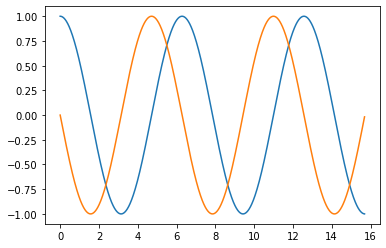

In [11]:
plt.plot(harmonic_data[:,0],harmonic_data[:,1]);
plt.plot(harmonic_data[:,0],harmonic_data[:,2]);

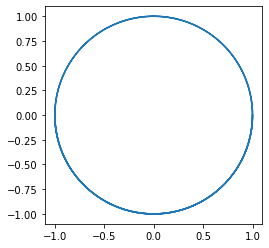

In [12]:
plt.plot(harmonic_data[:,1],harmonic_data[:,2]);
plt.axis('square');

In [13]:
#make 3d plot of chaotic system data for rossler and lorenz systems
# copied from https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook
# and https://plotly.com/python/3d-line-plots/
def plot_3d_custom(data_3d):
    # Configure the trace.
    trace = go.Scatter3d(
        x=data_3d[:,1],  # <-- Put your data instead
        y=data_3d[:,2],  # <-- Put your data instead
        z=data_3d[:,3],  # <-- Put your data instead
        mode='lines',
#         marker={
#             'size': 2,
#             'opacity': 0.8,
#         },
        line=dict(
        color='darkblue',
        width=2
        )
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)

In [14]:
rossler_data = ghk_rk4(200, [0.0, 0.0, -6.78, 0.02], .01, derivs_Rossler)

In [15]:
plot_3d_custom(rossler_data)

In [16]:
lorenz_data = ghk_rk4(50, [0.0, 1.0, 1.0, 1.0], .01, derivs_Lorenz)

In [17]:
plot_3d_custom(lorenz_data)

In [18]:
# fig, axs = plt.subplots(3, 1, figsize=(10,25))
# axs[0].plot(lorenz_data[:,1], lorenz_data[:,2]);
# axs[0].set_title('$x(t)$ vs $y(t)$');
# axs[0].axis('square');
# axs[1].plot(lorenz_data[:,1], lorenz_data[:,3]);
# axs[1].set_title('$x(t)$ vs $z(t)$');
# axs[1].axis('square');
# axs[2].plot(lorenz_data[:,2], lorenz_data[:,3]);
# axs[2].set_title('$y(t)$ vs $z(t)$');
# axs[2].axis('square');

In [19]:
# fig, axs = plt.subplots(3, 1, figsize=(10,25))
# axs[0].plot(rossler_data[:,1], rossler_data[:,2]);
# axs[0].set_title('$x(t)$ vs $y(t)$');
# axs[0].axis('square');
# axs[1].plot(rossler_data[:,1], rossler_data[:,3]);
# axs[1].set_title('$x(t)$ vs $z(t)$');
# axs[1].axis('square');
# axs[2].plot(rossler_data[:,2], rossler_data[:,3]);
# axs[2].set_title('$y(t)$ vs $z(t)$');
# axs[2].axis('square');

In [20]:
# plot3d = plt.axes(projection='3d');
# plot3d.plot3D(lorenz_data[:,1],lorenz_data[:,2],lorenz_data[:,3]);
# plot3d.view_init(20,160)